In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.cleaning import get_types_col
from src.metrics import all_metrics


In [34]:
df_base = pd.read_csv('../data/training_inputs.csv', sep=';', decimal='.')
y = pd.read_csv('../data/training_outputs.csv', sep=';', decimal='.')
df_base = pd.merge(df_base, y, on='ID', how='inner')  

In [35]:
df = df_base.copy()

## 1: Traitement des données

--- 

Première étape pour un projet de data science: Nettoyer les données

In [36]:
df_base["Q66"].unique()

array(['true', 'false', nan, 'true '], dtype=object)

In [37]:
df, types = get_types_col(df)

Premier nettoiement des données et séparation des différents types de variables (qualitatives, quantitatives etc...)

#### Booléennes

In [38]:
df[types[0]].head(5)

,C5,C6,C7,Q7,Q16,Q52,Q53,Q54,Q55,Q56,...,Q69,Q70,Q71,Q72,Q73,Q74,Q75,C8,C14,C4
0,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,False,True,False,False,NaN,NaN,NaN,True,True,True
1,False,False,False,NaN,False,False,True,True,False,True,...,False,True,False,False,True,False,False,False,True,False
2,False,False,False,NaN,False,NaN,False,False,False,True,...,False,True,False,False,NaN,NaN,NaN,False,False,False
3,False,False,False,NaN,True,NaN,False,False,False,False,...,False,True,False,False,NaN,NaN,NaN,False,True,True
4,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,True,True,False,False,NaN,NaN,NaN,True,False,True


#### Qualitatives

In [39]:
df[types[1]].head(5)

,Q34,Q32,C9,Q36,Q2,Q39,Q11,C13,Q1,C12,Q12,Q29,Q3,Q28,C2,Q10,C3
0,ED,LC,RA,AC,ZA,NaN,D7,RC,HA,OB,EA,IA,UC,ZA,RA,PC,C
1,ED,LC,RA,AC,ZA,NaN,DS,RC,HC,OB,E8,ID,UC,ZF,RA,PC,C
2,EF,LA,RA,AD,ZA,NaN,D3,R7,HC,OC,EA,IA,UA,ZF,RC,PD,B
3,ED,LD,RA,AC,ZA,NaN,DB,RC,HC,OA,EA,IA,UC,ZA,RA,PA,C
4,ED,LD,RA,AC,ZA,NaN,DF,RC,HA,OB,EA,IA,UA,ZA,RA,PC,B


#### Quantitatives

In [40]:
df[types[2]].head(5)

,C10,C11,C15,C16,C17,C18,C19,S1,S2,S8,...,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51
0,8,2286,2,214,212,16,7,1.0,0,6,...,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0
1,166,2220,3,511,414,15,19,3.0,2,11,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,17,2265,4,407,405,17,8,NaN,0,1,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,16,2250,3,712,410,16,12,4.0,1,10,...,0.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0
4,23,2305,1,206,204,17,4,NaN,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


#### Temporelles

In [41]:
df[types[-1]].head(5)

,S3,S4,S5,S6,S7
0,2013-11-15,2014-02-22,2013-09-08,2013-09-07,2013-09-07
1,2013-11-15,2014-08-07,2013-04-18,2013-09-14,2014-03-21
2,2013-11-15,2013-11-05,2013-11-05,NaT,NaT
3,2013-11-15,2014-05-30,2013-07-03,2014-01-30,2014-05-18
4,2013-11-15,2013-09-22,2013-09-22,NaT,NaT


### Présentation du problème

On cherche à prédire la variable "TARGET", qui contient 20% de 1 (pour 80% de 0)

In [42]:
df["TARGET"].mean()

0.19359515485975518

Il est évident que dans cette configuration, certaines métriques comme l'accuracy ne sont pas très pertinentes

In [43]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [44]:
print(classification_report(df["TARGET"].to_numpy(), [0]*df.shape[0]))

              precision    recall  f1-score   support

       False       0.81      1.00      0.89     68971
        True       0.00      0.00      0.00     16558

    accuracy                           0.81     85529
   macro avg       0.40      0.50      0.45     85529
weighted avg       0.65      0.81      0.72     85529



/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


D'autres métriques telles que le F1 score ou le ROC AUC sont plus pertinentes

In [45]:
roc_auc_score(df["TARGET"].to_numpy(), [0]*df.shape[0])

0.5

In [46]:
float(roc_auc_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0])))

0.4976093508399154

In [61]:
f1_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0]))

0.2770095218868813

On peut montrer analytiquement facilement que pour un prédicteur aléatoire (d'une loi uniforme), on peut choisir le seuil tel que l'espérance du F1 score est de $2*\frac{\lambda}{1+\lambda}$ où $\lambda$ est la part de label 1 dans le dataset (dans notre cas $\approx 0.2$ donc le F1 score d'un prédicteur aléatoire peut atteindre $\approx 1/3$)

#### Gérer les NAN

Pour les variables catégorielles, on se permet de remplir simplement par "Unknown" les variables avec des NaN

In [48]:
df.fillna({col: "Unknown" for col in types[1]}, inplace=True)
df[types[1]].head(5)

,Q34,Q32,C9,Q36,Q2,Q39,Q11,C13,Q1,C12,Q12,Q29,Q3,Q28,C2,Q10,C3
0,ED,LC,RA,AC,ZA,Unknown,D7,RC,HA,OB,EA,IA,UC,ZA,RA,PC,C
1,ED,LC,RA,AC,ZA,Unknown,DS,RC,HC,OB,E8,ID,UC,ZF,RA,PC,C
2,EF,LA,RA,AD,ZA,Unknown,D3,R7,HC,OC,EA,IA,UA,ZF,RC,PD,B
3,ED,LD,RA,AC,ZA,Unknown,DB,RC,HC,OA,EA,IA,UC,ZA,RA,PA,C
4,ED,LD,RA,AC,ZA,Unknown,DF,RC,HA,OB,EA,IA,UA,ZA,RA,PC,B


In [78]:
list_types = ["Bool", "Qualitative", "Quantitative", "Temporelle"]
to_drop_nan = set()

for cat, list_col in zip(list_types, types):
    if cat == "Qualitative":
        continue

    missing_rate = df[list_col].isna().mean()
    print(cat, "\n", f"Nombre de variables : {len(list_col)}\n", "% de colonnes qui contiennent:\n")
    print(f" Au moins un Nan {len(missing_rate[missing_rate > 0.].index)/len(list_col)}")
    print(f" Au moins 10% de NaN {len(missing_rate[missing_rate > 0.1].index)/len(list_col)}")
    print(f" Au moins 50% de NaN: {len(missing_rate[missing_rate > 0.5].index)/len(list_col)}")
    print(f" Au moins 80% de NaN {len(missing_rate[missing_rate > 0.8].index)/len(list_col)}")

    to_drop_nan.update(missing_rate[missing_rate > 0.5].index)
    
    print('\n', "-"*50, "\n")

print("Colonnes à supprimer:", to_drop_nan)


Bool 
 Nombre de variables : 32
 % de colonnes qui contiennent:

 Au moins un Nan 0.8125
 Au moins 10% de NaN 0.28125
 Au moins 50% de NaN: 0.0625
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Quantitative 
 Nombre de variables : 51
 % de colonnes qui contiennent:

 Au moins un Nan 0.7254901960784313
 Au moins 10% de NaN 0.19607843137254902
 Au moins 50% de NaN: 0.13725490196078433
 Au moins 80% de NaN 0.09803921568627451

 -------------------------------------------------- 

Temporelle 
 Nombre de variables : 5
 % de colonnes qui contiennent:

 Au moins un Nan 0.4
 Au moins 10% de NaN 0.4
 Au moins 50% de NaN: 0.0
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Colonnes à supprimer: {'Q18', 'Q15', 'Q52', 'Q38', 'Q6', 'Q17', 'Q40', 'Q7', 'Q37'}


La plupart des variables contiennent au moins un NaN mais on voit que la plupart contiennent moins de 10% de NaN

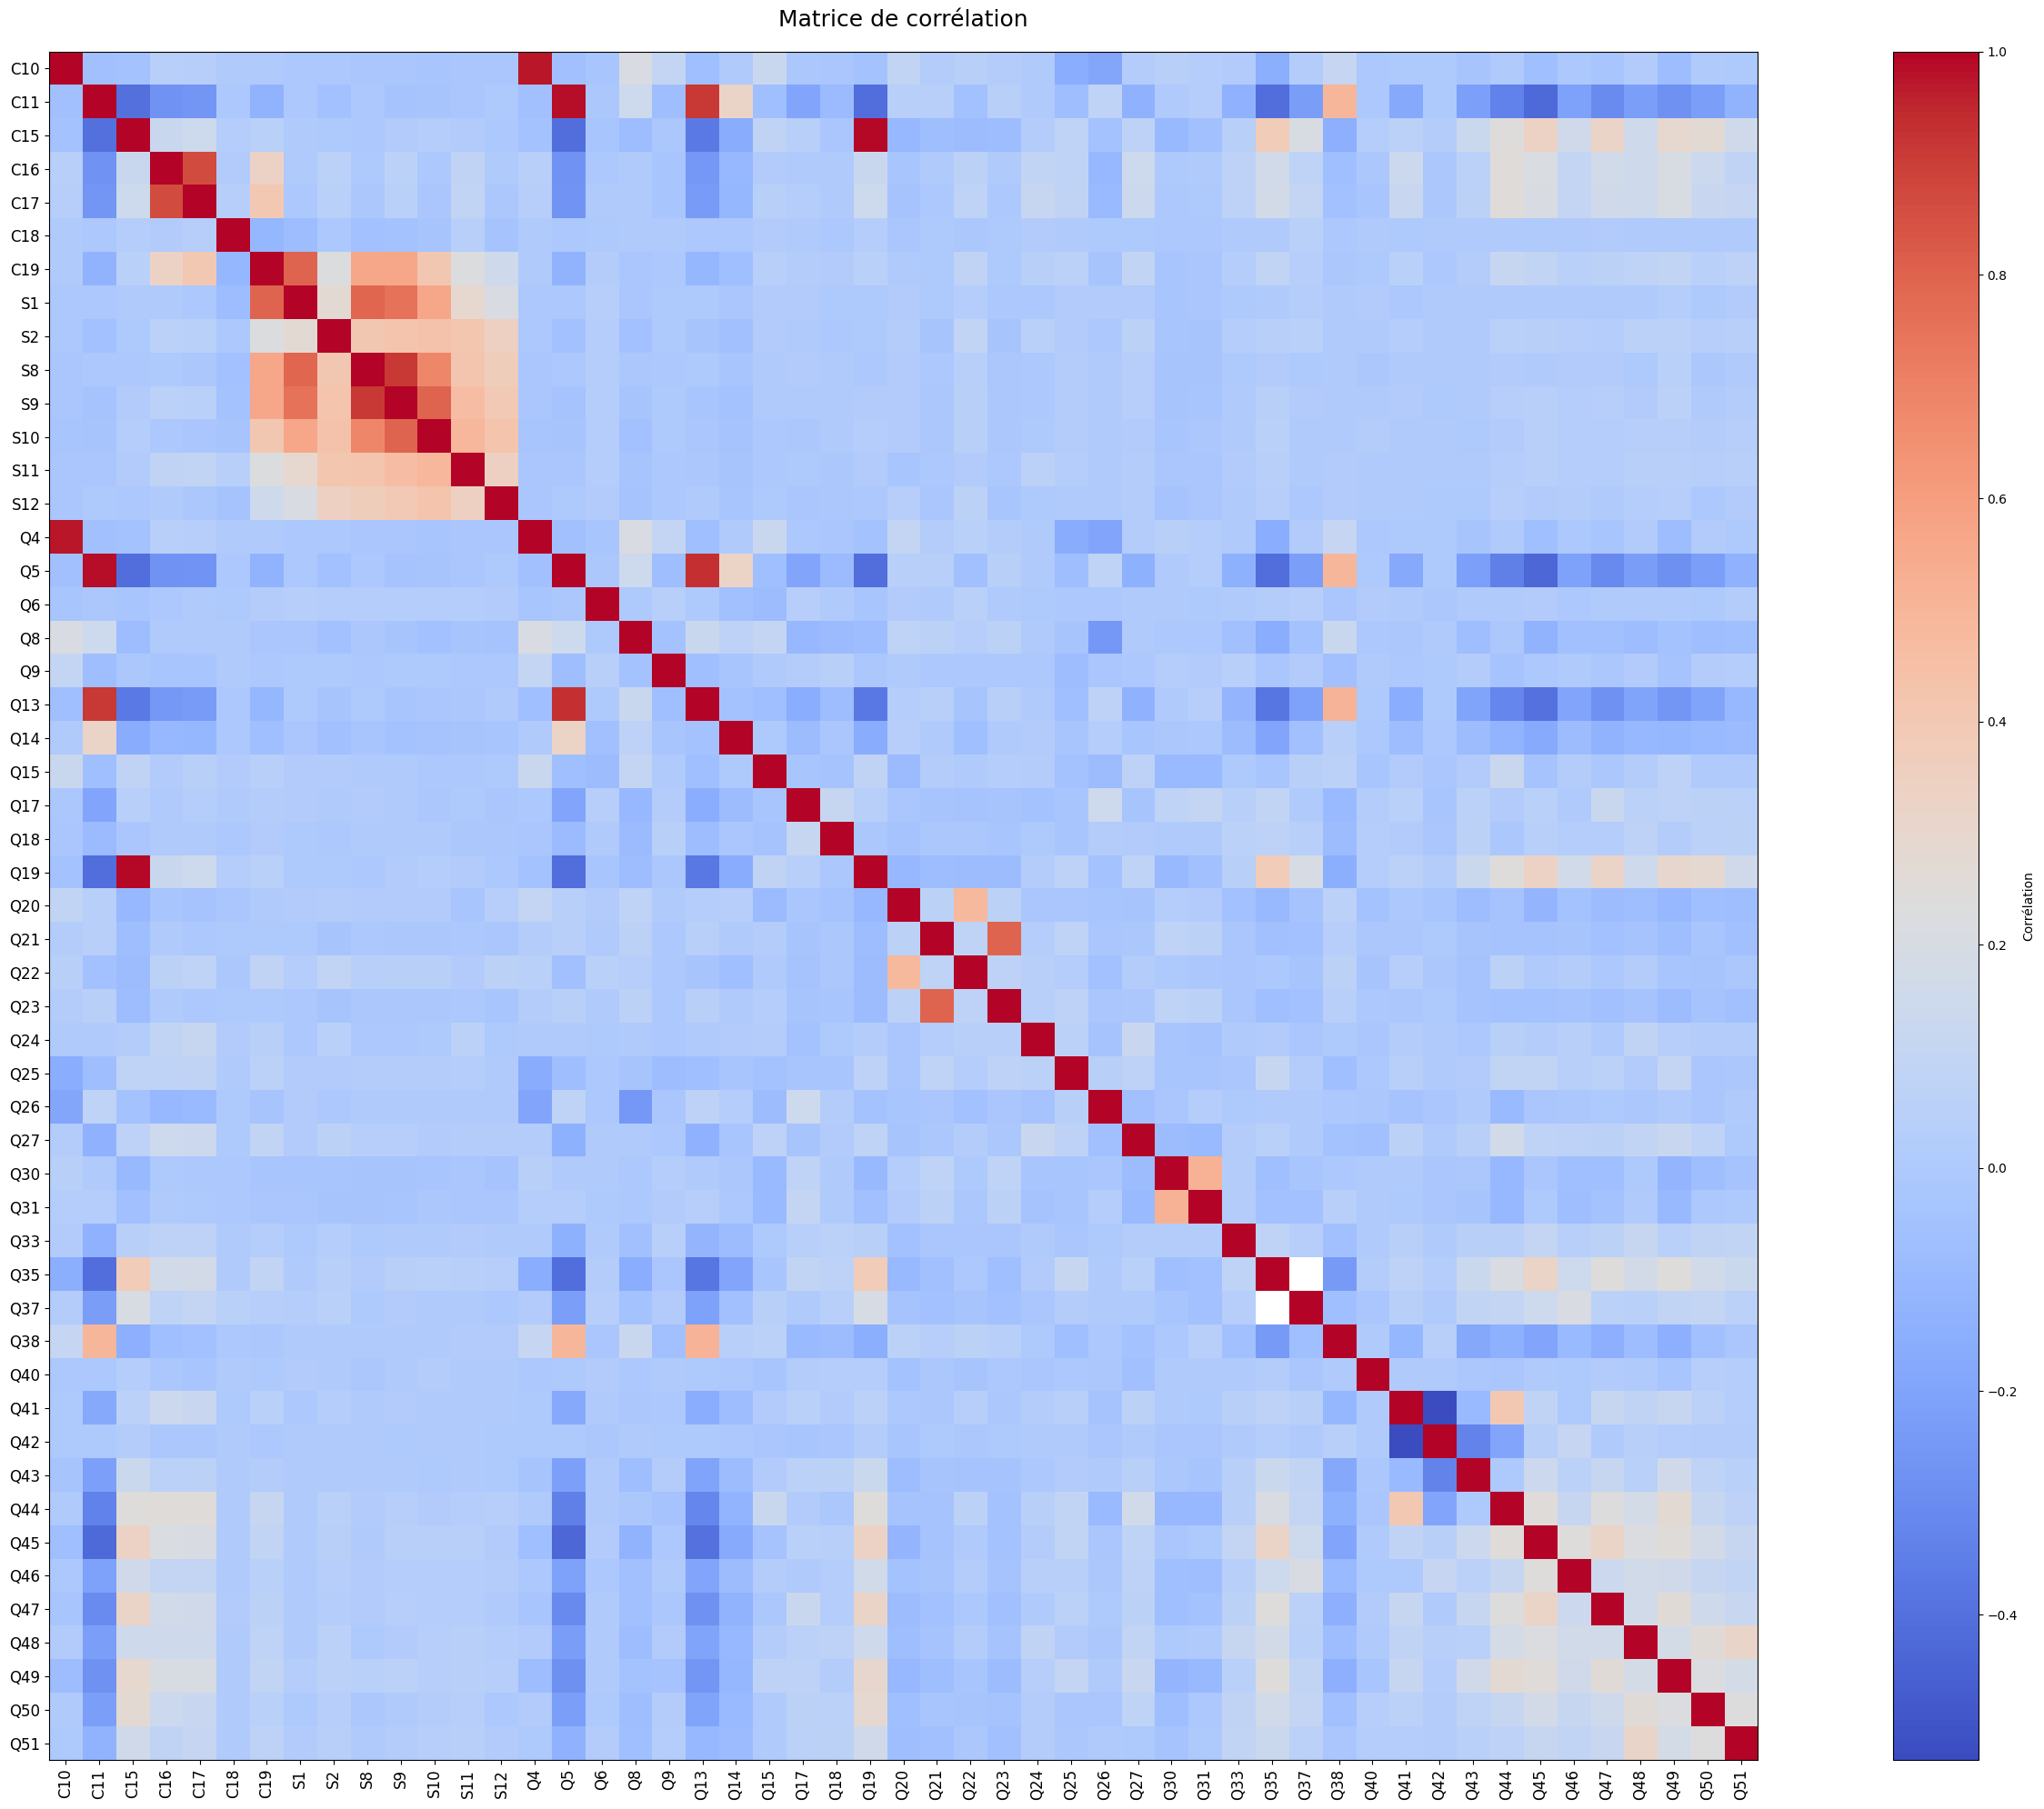

In [79]:
float_vars = df[types[2]]

cov_matrix = float_vars.corr()

plt.figure(figsize=(30, 20))
plt.imshow(cov_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Corrélation")
plt.title('Matrice de corrélation', pad=20, fontsize=18)

plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=90, fontsize=12)
plt.yticks(range(len(cov_matrix.columns)), cov_matrix.columns, fontsize=12)

plt.tight_layout()
plt.show()

In [80]:
to_drop_corr = set()

for i in range(len(cov_matrix.columns)):
    for j in range(i + 1, len(cov_matrix.columns)):
        if abs(cov_matrix.iloc[i, j]) > 0.8:
            colname_1 = cov_matrix.columns[j]
            colname_2 = cov_matrix.columns[i]
            argmin = np.argmin(np.abs(df[[colname_1, colname_2, "TARGET"]].corr().to_numpy()[-1,:2]))
            colname = colname_1 if argmin==0 else colname_2
            to_drop_corr.add(colname)

print("Colonnes à supprimer pour corrélation > 80% :")
print(to_drop_corr)


Colonnes à supprimer pour corrélation > 80% :
{'C15', 'C10', 'Q13', 'C17', 'S8', 'C11'}


On supprime aussi les variables qualitatives qui ont trop de valeurs différentes (risque d'exploser le nombre de feature car on les converti en OHE). Si les variables avaient un sens plus concret, je déconseillerai cette méthode et je chercherai plutot à créer des variables a partir de celles ci. Mais ici si on a deux variables qui ont 30 valeurs différentes on doit crée 58 dummie ce qui est très élevé

In [81]:
to_drop_uni = set()

for col in types[1]:
    n_unique = df[col].nunique()
    if n_unique>10:
        to_drop_uni.add(col)

print("Colonnes à supprimer (trop de valeurs différentes):")
print(to_drop_uni)      

Colonnes à supprimer (trop de valeurs différentes):
{'Q28', 'Q34', 'Q12', 'Q11'}


In [ ]:
for colname in types[-1]:
    df[colname] = df[colname].dt.month

In [83]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [84]:
to_drop = to_drop_corr.union(to_drop_nan).union(to_drop_uni)

/tmp/ipykernel_38396/2516134041.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


<Figure size 1000x600 with 0 Axes>

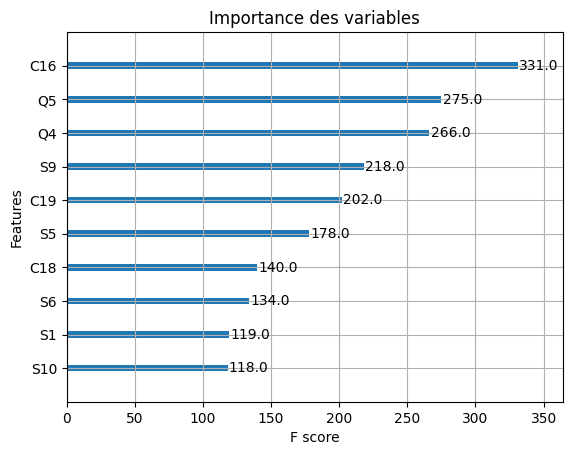

In [85]:
X = df.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID']).fillna(0)
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(scale_pos_weight=scale_pos_weight, 
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Importance des variables")
plt.show()

              precision    recall  f1-score   support

       False       0.88      0.74      0.81     13794
        True       0.35      0.59      0.44      3312

    accuracy                           0.71     17106
   macro avg       0.62      0.67      0.62     17106
weighted avg       0.78      0.71      0.74     17106

AUC: 0.7348
AUPR: 0.3962
FPR95% : 0.7523


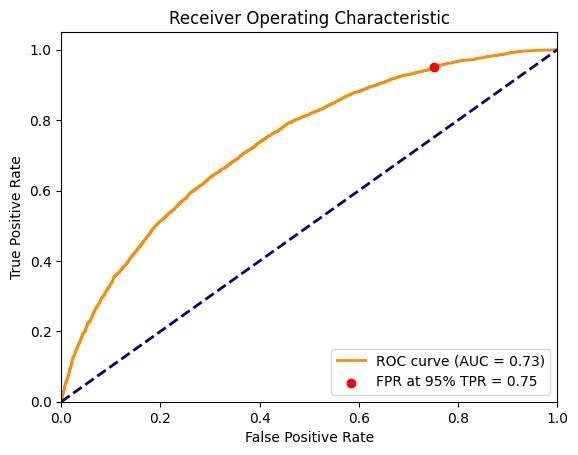

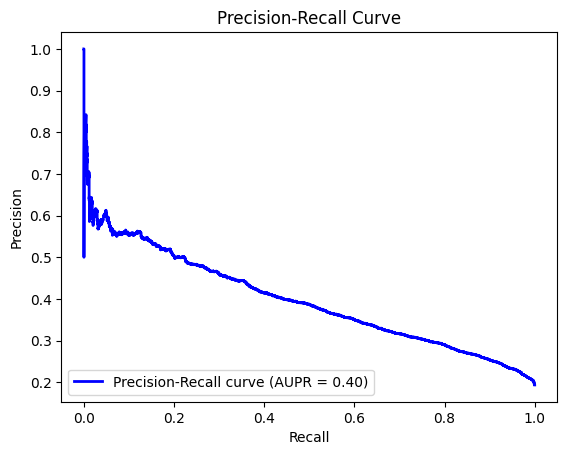

In [86]:
_ = all_metrics(y_test, y_pred_prob, verbose=True)

/home/onyxia/work/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False       0.89      0.70      0.79     13794
        True       0.34      0.64      0.44      3312

    accuracy                           0.69     17106
   macro avg       0.62      0.67      0.61     17106
weighted avg       0.78      0.69      0.72     17106

AUC: 0.7363
AUPR: 0.3928
FPR95% : 0.7343


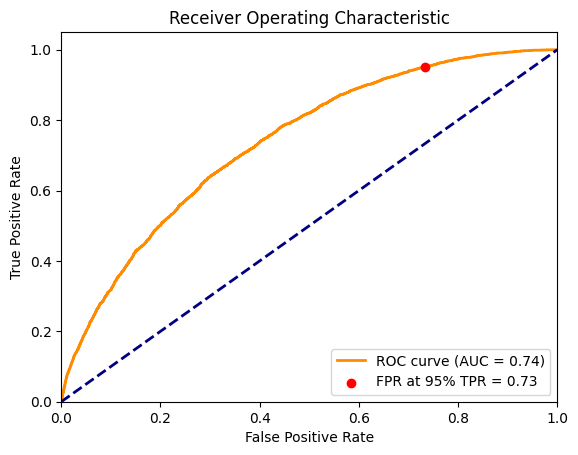

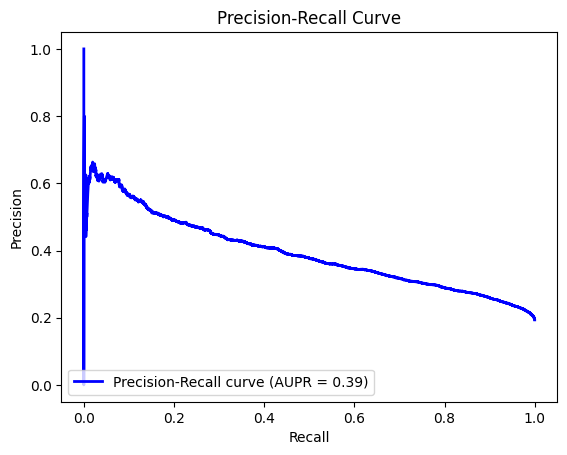

In [87]:
X = df.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID'])
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      use_label_encoder=False,
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

_ = all_metrics(y_test, y_pred_prob, verbose=True)

Ici on voit que rajouter le paramètre de "poids" dans XGBoost ne change pas vraiment les résultats (étant donné que je sélectionne après le threshold qui maximise le F1 score)

Nos résultats ne sont pas terribles, (en plus si on ne retire aucune variables, on obtient a peu près les même résultats)

In [88]:
from autogluon.tabular  import TabularDataset, TabularPredictor

In [89]:
dft = df.copy()
for col in types[0]:
    dft[col] = dft[col].fillna(0)
for col in types[2]:
    dft[col] = dft[col].fillna(df[col].median())

for col in types[3]:
    dft[col] = dft[col].fillna(df[col].median())

In [93]:
predictor = TabularPredictor(
    label='TARGET',
    eval_metric='f1',
    problem_type='binary'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250122_224443"


In [94]:
validation_df = dft.sample(frac=0.2, random_state=42)
train_df = dft.drop(validation_df.index)

In [99]:
predictor.fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=50,
    hyperparameters={
        'CAT': {
            'iterations': 10,
            'early_stopping_rounds': 20,
            'learning_rate': 0.1
        },
        'GBM': {
            'n_estimators': 10,
            'early_stopping_rounds': 20,
            'learning_rate': 0.1},
        'XGB':{
            'n_estimators': 10,
            'early_stopping_rounds': 20,
            'learning_rate': 0.1
        },
        'FASTAI': {
        }
    }
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Debian 6.1.124-1 (2025-01-12)
CPU Count:          104
Memory Avail:       851.27 GB / 1007.33 GB (84.5%)
Disk Space Avail:   0.01 GB / 9.75 GB (0.1%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGlu

KeyboardInterrupt: 